<a href="https://colab.research.google.com/github/kittikhun62/efficientnet_keras_transfer_learning/blob/master/regression_2Class_Unfreeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [1]:
import pandas as pd
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports

In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [4]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

#กำหนดค่าพารามิเตอร์


In [5]:
batch_size = 16

width = 150
height = 150

epochs = 1000 #จำนวนรอบในการ Train

NUM_TRAIN = 628  # จำนวนภาพ Train
NUM_TEST = 101 #จำนวนภาพ Test

dropout_rate = 0.3
input_shape = (height, width, 3) #ขนาด image enter

#Clone efficientnet repo


In [6]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1079, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 1079 (delta 121), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1079/1079), 13.94 MiB | 18.62 MiB/s, done.
Resolving deltas: 100% (618/618), done.
/content/efficientnet_keras_transfer_learning


In [7]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [8]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


16717576/16717576 [==============================] - 1s 0us/step


#load model


In [9]:
import sys
sys.path.append('/content/drive/My Drive/new/regression.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [10]:
#load model 
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/new/regression.h5')
height = width = model.input_shape[1]

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 2562      
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 4,052,129
Trainable params: 2,565
Non-trainable params: 4,049,564
__________________________________________

In [12]:
df = pd.read_csv (f'/content/drive/My Drive/data - 2 class เพิ่ม 4 paper.csv')
df

,No,Name_file,Name_Paper,journal,path_Picture,detail,Class,BET,Size(mico),Class_01
0,1,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom1,0-800,135.06,10,0
1,2,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom2,0-800,135.06,10,0
2,3,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom3,0-800,135.06,10,0
3,4,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom4,0-800,135.06,10,0
4,5,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom5,0-800,135.06,10,0
...,...,...,...,...,...,...,...,...,...,...
825,826,1-s2.0-S2095268622000210-main,"Integration of preparation of K, Na-embedded a...","Dingzheng Wang,Deqing Zhu,Jian Pan, Zhengqi Gu...",/content/drive/My Drive/new train/1-s2.0-S2095...,zoom21,0-800,301.70,10,0
826,827,1-s2.0-S2095268622000210-main,"Integration of preparation of K, Na-embedded a...","Dingzheng Wang,Deqing Zhu,Jian Pan, Zhengqi Gu...",/content/drive/My Drive/new train/1-s2.0-S2095...,zoom22,0-800,301.70,10,0
827,828,1-s2.0-S2095268622000210-main,"Integration of preparation of K, Na-embedded a...","Dingzheng Wang,Deqing Zhu,Jian Pan, Zhengqi Gu...",/content/drive/My Drive/new train/1-s2.0-S2095...,zoom23,0-800,301.70,10,0
828,829,1-s2.0-S2095268622000210-main,"Integration of preparation of K, Na-embedded a...","Dingzheng Wang,Deqing Zhu,Jian Pan, Zhengqi Gu...",/content/drive/My Drive/new train/1-s2.0-S2095...,zoom24,0-800,301.70,10,0


In [13]:
import os

In [14]:
val = df[df['No'].between(629,729)]
train = df[df['No'].between(1,628)]

In [15]:
DATA_PATH = '/content/drive/My Drive/new project'
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'validation')
print(validation_dir)

/content/drive/My Drive/new project/train
/content/drive/My Drive/new project/validation



#Train

In [16]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'path_Picture',
        y_col = 'BET',
        class_mode = 'other',
        target_size=(height, width),
        batch_size=batch_size)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe = val,
        directory = validation_dir,
        x_col = 'path_Picture',
        y_col = 'BET',
        class_mode = 'other',
        target_size=(height, width),
        batch_size=batch_size)

Found 628 validated image filenames.
Found 101 validated image filenames.


In [18]:
# multiply_16
# set 'multiply_16' and following layers trainable
model.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False  

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 2562      
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 4,052,129
Trainable params: 4,010,113
Non-trainable params: 42,016
_________________________________________

In [20]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-20-caa7b37242a8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/1000
39/39 [==============================] - 150s 3s/step - loss: 605954.6875 - mae: 615.4678 - val_loss: 222434.9531 - val_mae: 456.5224
Epoch 2/1000
39/39 [==============================] - 3s 83ms/step - loss: 603689.2500 - mae: 613.4155 - val_loss: 222292.4844 - val_mae: 456.9071
Epoch 3/1000
39/39 [==============================] - 4s 85ms/step - loss: 604680.7500 - mae: 615.4921 - val_loss: 223010.5000 - val_mae: 457.4432
Epoch 4/1000
39/39 [==============================] - 3s 69ms/step - loss: 604250.3750 - mae: 616.1613 - val_loss: 222473.7031 - val_mae: 456.8561
Epoch 5/1000
39/39 [==============================] - 4s 88ms/step - loss: 600478.8125 - mae: 613.8466 - val_loss: 223189.7656 - val_mae: 457.3935
Epoch 6/1000
39/39 [==============================] - 4s 87ms/step - loss: 605261.7500 - mae: 615.7400 - val_loss: 222950.4375 - val_mae: 456.4612
Epoch 7/1000
39/39 [==============================] - 3s 72ms/step - loss: 598659.6875 - mae: 611.9658 - val_loss: 224

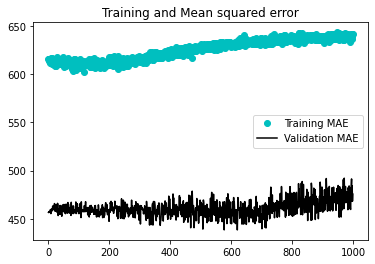

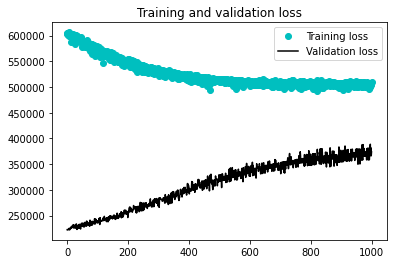

In [21]:

loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs_x = range(len(loss))

plt.plot(epochs_x, mae, 'co', label='Training MAE')
plt.plot(epochs_x, val_mae, 'k', label='Validation MAE')
plt.title('Training and Mean squared error')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'co', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
     

In [22]:
epochs_x

range(0, 1000)

#Download the model


In [23]:
os.makedirs('./content/drive/My Drive/new', exist_ok=True)
model.save('./content/drive/My Drive/new/regression_unfreeze.h5')

In [24]:
from google.colab import files


In [25]:
files.download('./content/drive/My Drive/new/regression_unfreeze.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>